In [1]:
# Allsky chart code based on https://github.com/skyfielders/python-skyfield/discussions/636

In [2]:
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from skyfield.api import Star, load, wgs84, N, S, W, E, Angle
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN
from skyfield.data import hipparcos, mpc, stellarium
from skyfield.projections import build_stereographic_projection
from datetime import datetime
from pytz import timezone
import re

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
zone = timezone('US/Pacific')
ts = load.timescale()
t = ts.from_datetime(zone.localize(datetime(2023,9,21,21,0,0)))
seattle = wgs84.latlon(47.61352679507131, -122.30535433025425, elevation_m=100)
location = seattle
#t = ts.from_datetime(zone.localize(datetime(2023,11,2,1,0,0)))
#t_jupiter = ts.utc(2023, 9, range(15, 75))
# 180 = South, 0 = North
degrees = 0.0
# Set zenith
zenith = location.at(t).from_altaz(alt_degrees=90, az_degrees=degrees) 

In [4]:
eph = load('de421.bsp')
earth = eph['earth']

eph_obj = ('moon', 'mercury', 'venus', 'mars', 'jupiter barycenter', 'saturn barycenter',
           'uranus barycenter', 'neptune barycenter')
radius_km = (1737.4, 2437.7, 6051.8, 3389.5, 69911, 58232, 25362, 24622)
radius_km_dict = dict(zip(eph_obj, radius_km))

In [5]:
# The Hipparcos mission provides our star catalog.
with load.open(hipparcos.URL) as f:
    stars = hipparcos.load_dataframe(f)

In [6]:
# The constellation outlines come from Stellarium. We make a list
# of the stars at which each edge starts, and the star at which each edge
# ends

with load.open('constellationship.fab') as f:
    constellations = stellarium.parse_constellations(f)
    
edges = [edge for name, edges in constellations for edge in edges]
edges_star1 = [star1 for star1, star2 in edges]
edges_star2 = [star2 for star1, star2 in edges]

In [7]:
# Center the chart on the zenith
projection = build_stereographic_projection(zenith)
field_of_view_degrees = 180.0
limiting_magnitude = 6.0

In [86]:
# Now that we have constructed our projection, compute the x and y
# coordinates that each star and the jupiter will have on the plot
loc = earth + location

star_positions = earth.at(t).observe(Star.from_dataframe(stars))
#star_alt = star_positions.apparent().altaz()[0].degrees
#star_positions = star_positions[ star_alt > 0 ]
stars['x'], stars['y'] = projection(star_positions)

x = {}
y = {}
altaz_dist = {}
dist_km = {}
apparent_diam_arcsec = {}

for obj in eph_obj:
    obs = loc.at(t).observe(eph[obj])
    x[obj], y[obj] = projection(obs)
    altaz_dist[obj] = obs.apparent().altaz()
    dist_km[obj] = altaz_dist[obj][-1].km

    apparent_diam_arcsec[obj] = Angle(radians=np.arcsin(radius_km_dict[obj] / dist_km[obj]) * 2.0).arcseconds()

In [87]:
# Create a True/False mask marking the stars bright enough to be
# included in our plot. And go ahead and compute how large their
# markers will be on the plot

bright_stars = (stars.magnitude <= limiting_magnitude)
magnitude = stars['magnitude'][bright_stars]
marker_size = (0.5 + limiting_magnitude - magnitude) ** 2.0

In [88]:
# The constellation lines will each begin at the x, y of one star and end
# at the x, y of another. We have to "rollaxis" the resulting coordinate
# array into the shape that matplotlib expects.

xy1 = stars[['x', 'y']].loc[edges_star1].values
xy2 = stars[['x', 'y']].loc[edges_star2].values
lines_xy = np.rollaxis(np.array([xy1, xy2]), 1)

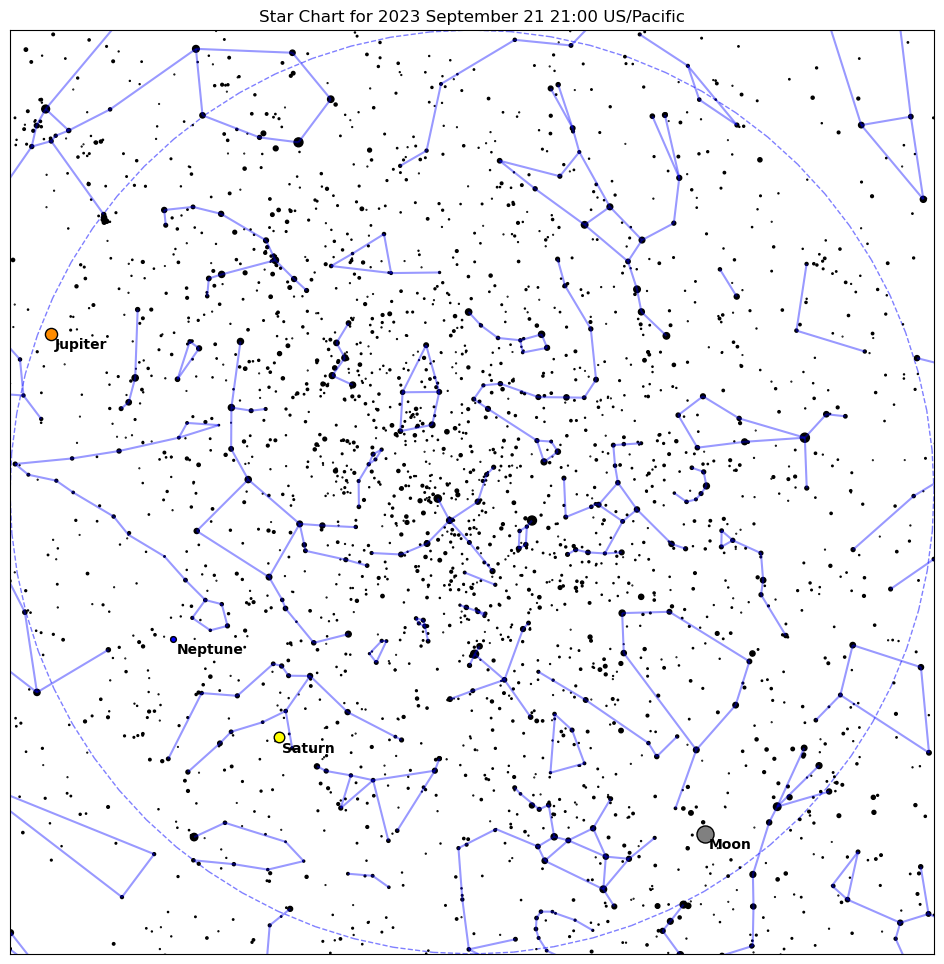

In [89]:
# Time to build the figure!
angle = np.pi - field_of_view_degrees / 360.0 * np.pi
limit = np.sin(angle / (1.0 - np.cos(angle)))



fig, ax = plt.subplots(figsize=[12, 12], facecolor='white')

# Draw horizon as a dashed line
# 24 points horizon

horizon = []
h0 = projection(location.at(t).from_altaz(alt_degrees=0, az_degrees=0.0))
for i in range(1, 73):
    delta = 5.0
    current = i*delta
    h1 = projection(location.at(t).from_altaz(alt_degrees=0, az_degrees=current))
    horizon.append([h0, h1])
    h0 = h1
    
ax.add_collection(LineCollection(horizon, colors='#00f2', linewidths=1, linestyle='dashed',
                                 zorder=-1, alpha=0.5))

# Draw the constellation lines

ax.add_collection(LineCollection(lines_xy, colors=(0, 0, 1, .4)))

# Draw the stars

ax.scatter(stars['x'][bright_stars], stars['y'][bright_stars],
           s=marker_size, color='k', zorder=-1)

# Draw the jupiter positions

color = {'moon': 'gray',
         'mercury': 'brown',
         'venus': 'blue',
         'mars': 'red',
         'jupiter barycenter': 'darkorange',
        'saturn barycenter': 'yellow',
        'uranus barycenter': 'teal',
        'neptune barycenter': 'blue'} 
offset = 0.008

for obj in eph_obj:
    if altaz_dist[obj][0].degrees > 0:
        # Make planet marker size relative to the log of the apparent diam
        size = math.log(apparent_diam_arcsec[obj])*20
        ax.scatter(x[obj], y[obj], s=size, marker='o', c=color[obj], edgecolors='black', zorder=3)
        #time = t.astimezone(zone).strftime('%m-%d')
        name = re.split("\s", obj)[0].capitalize()
        text = ax.text(x[obj] + offset, y[obj] - offset, name, color='black',
                       ha='left', va='top', fontsize=10, weight='bold')

#for xi, yi, tstr in zip(x[obj], y[obj], eph_obj):
#    time = t.utc_strftime('%m-%d')
#    tstr = tstr.lstrip('0')
#    text = ax.text(xi + offset, yi - offset, tstr, color=jupiter_color,
#                   ha= 'left', va='top', fontsize=10, weight='bold')

# Finally, title the plot and set some final parameters

angle = np.pi - field_of_view_degrees / 360.0 * np.pi
limit = np.sin(angle / (1.0 - np.cos(angle)))

ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_aspect(1.0)
ax.set_title('Star Chart for {} {}'.format(
    t.astimezone(zone).strftime('%Y %B %d %H:%M'),
    zone
))

plt.show()

In [ ]:
# TODO: Plot ecliptic
# Turn into Streamlit app
# Minimize stars and contellations below horizon, or add an overlay shade